In [398]:
%%capture
!pip install ht CoolProp fluids xlrd xlwt tikzplotlib

In [489]:
%matplotlib widget
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xlwt as xw
lista_data = []
import matplotlib.pyplot as plt
import ht,fluids,os,socket
import CoolProp as cp
from IPython.display import Latex
from prop_fluidos_intercambiadores import fluido_intercambiador
import time,datetime
from tikzplotlib import save as savetikz
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [490]:
#constantes de calculo
g = 9.8; cal2joule = 4.184
###########################################################
#           DATOS  del Intercambiador  
###########################################################
# Definición de Flujos
#Crudo = fluido_intercambiador('Crudo') 
#Glicol = fluido_intercambiador('Glycol')
# Temperaturas
T_crudo_e = 55.8 ##(al menos Twat + 20)
T_crudo_WAT = 32
T_crudo_s = T_crudo_WAT-10
T_crudo_s = 52.5

T_glycol_e = 38.8
T_glycol_s = 40
Caudal_crudo = 2.265 * 1e-3/60  #20L/min en m3/s

D_externo_1 = 33.44e-3

#Considerando Schedule 160 (para soportar 1500psi)
espesor_tubo_1 = 8.3e-3#6.35e-3
espesor_tubo_1b = 6.35e-3

D_interno_1 = D_externo_1-2*espesor_tubo_1
D_interno_1b = D_externo_1-2*espesor_tubo_1b

D_externo_2 = 114.3e-3
espesor_tubo_2 = 6.02e-3
#Supongo Schedule STD, presion de trabajo 40 psi
D_interno_2 = D_externo_2-2*espesor_tubo_2
Longitud = 16

D_interno_1 = 0.8366*25.4e-3

In [492]:
B = pd.read_excel('Densidad y viscosidad diesel.xlsx',thousands=',',sheet_name=1,skiprows=3)
Temps  = pd.to_numeric(B['T(K)'],errors='ignore').to_numpy()
Viscosidad = pd.to_numeric(B['Viscosidad (cp)'],errors='ignore').to_numpy()
Densidad = pd.to_numeric(B['Densidad (g/ml)'],errors='ignore').to_numpy()*1000


## ajuste
P1 = np.polyfit(1/Temps,np.log(Viscosidad),1)
viscosidad_f = np.poly1d(P1)
temperaturas = np.linspace(Temps[0]-10,Temps[-1]+10,100)
P2 = np.polyfit(Temps,Densidad,1)
densidad_f = np.poly1d(P2)

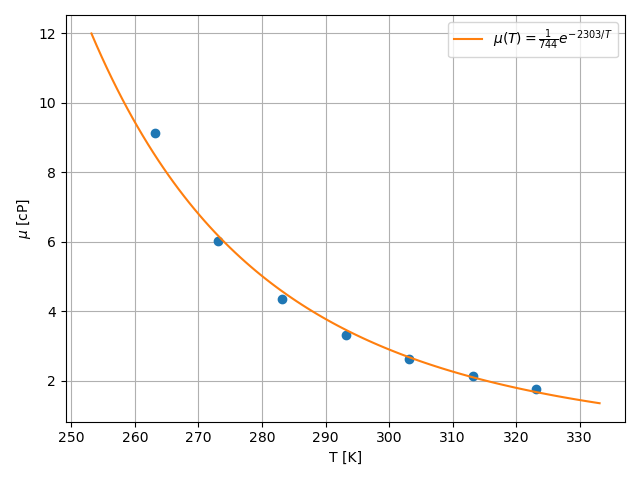

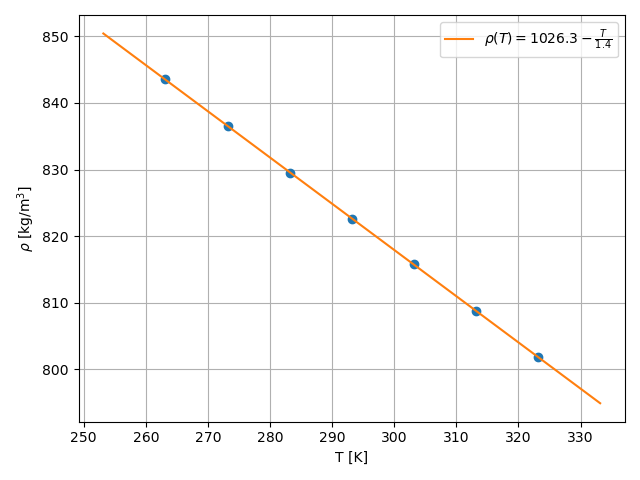

In [493]:
fig1,ax1 = plt.subplots()
ax1.plot(Temps,Viscosidad,'o')
etiqueta_viscosidad = f'$\mu(T)=\\frac{{1}}{{{1/np.exp(P1[1]):.0f}}}e^{{-{P1[0]:.0f}/T}}$'
ax1.plot(temperaturas,np.exp(viscosidad_f(1/temperaturas)),label=etiqueta_viscosidad)
#ax.plot(temperaturas,np.exp(P1[1])*np.exp(P1[0]/temperaturas))
ax1.legend()
ax1.set_ylabel('$\mu$ [cP]')
ax1.set_xlabel('T [K]')
ax1.grid()
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/viscosidad.tikz')

fig2,ax2 = plt.subplots()
ax2.plot(Temps,Densidad,'o')
etiqueta_densidad = f'$\\rho(T)={P2[1]:.1f}-\\frac{{T}}{{{-1/P2[0]:.1f}}}$'
ax2.plot(temperaturas,densidad_f(temperaturas),label=etiqueta_densidad)
ax2.legend()
ax2.grid()
ax2.set_xlabel('T [K]')
ax2.set_ylabel(r'$\rho$ [kg/m$^3$]')
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/densidad.tikz')

In [494]:
A = pd.read_excel('Pruebas diesel 19-08-2022.xlsx',thousands=',')
#A = A[:944]
#A.drop(A.columns[[1]],axis=1,inplace=True)
A=A.drop(A.index[[0,1,2]])


In [495]:
indices1 = np.logical_not(A['Date/Time'].isnull())
A1 = A[indices1]
indices2 = np.logical_not(A1['PT-01'].isnull())
A2 = A1[indices2]
indices3 = np.logical_not(np.logical_or(A2['PT-01'] == '???', A2['PT-01']=='?????'))
A3 = A2[indices3]


# variable tiempo
time1 = pd.to_datetime(A3['Date/Time'],errors='ignore').to_numpy()
time1 = [time1i.hour*3600+time1i.minute*60+time1i.second for time1i in time1]

#variables presion
PT01,PT02,PT03,PT04,PT05,PT06  = [pd.to_numeric(A3.iloc[:,i].to_numpy()) for i in range(1,7)]
# variables temperaturas
TE_s = np.tile(np.zeros_like(PT01),[12,1])
for i in range(9,21):
    TE_s[i-9] = pd.to_numeric(A3.iloc[:,i].to_numpy()) 
# variable caudal
Caudal = pd.to_numeric(A3['CORIOLIS_VolFlow'],errors='ignore').to_numpy()
densidad = pd.to_numeric(A3['CORIOLIS_Density'],errors='ignore').to_numpy()
Caudal[156:] = Caudal[156:]/1e3
# para -175 motor corresponde 2.465 l/min
Vmotor = pd.to_numeric(A3.iloc[:,30].to_numpy()) 
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A3.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]
Tchiller_pv[Tchiller_pv =='???'] = np.NaN
Tchiller_sp[Tchiller_sp =='???'] = np.NaN
dt = 30
N = len(Vmotor)
time1  = np.arange(0,dt*N,dt)/3600

#referencias
#datos valores sin flujo
PT01_ref,PT02_ref,PT03_ref,PT04_ref,PT05_ref,PT06_ref = [PTi[:160].mean() for PTi in [PT01,PT02,PT03,PT04,PT05,PT06]]
#PT01_ref,PT02_ref,PT03_ref,PT04_ref,PT05_ref,PT06_ref = [6.46, -1.14, 1.17, 0.3175, 5.91625, -0.3475]
PT01 = PT01 - PT01_ref
PT02 = PT02 - PT02_ref
PT03 = PT03 - PT03_ref
PT04 = PT04 - PT04_ref
PT05 = PT05 - PT05_ref
PT06 = PT06 - PT06_ref
PT_ref = np.array([PT01_ref,PT02_ref,PT03_ref,PT04_ref,PT05_ref,PT06_ref])

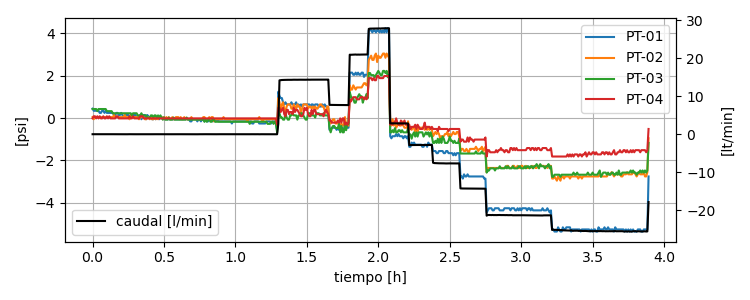

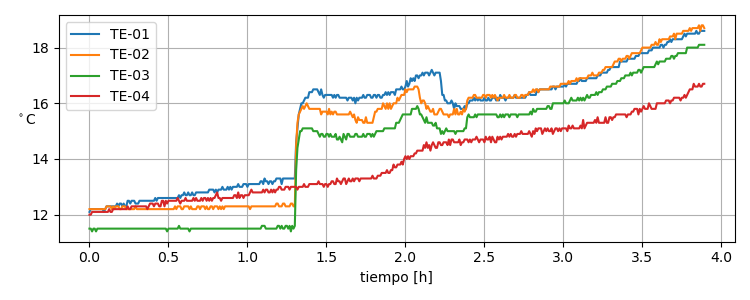

In [496]:
fig1, ax1 = plt.subplots(1,1,figsize=(7.5,3))
fig2, ax2 = plt.subplots(1,1,figsize=(7.5,3))
#ax1,ax2 = ax

ax1.plot(time1,PT01,label = 'PT-01')
ax1.plot(time1,PT02,label = 'PT-02')
ax1.plot(time1,PT03,label = 'PT-03')
ax1.plot(time1,PT04,label = 'PT-04')
ax1.grid()

ax1b = ax1.twinx()
ax1b.plot(time1,Caudal,label= 'caudal [l/min]',color='k')
ax1.set_ylabel('[psi]',rotation=90)
ax1b.set_ylabel('[lt/min]')
#ax1.plot(time1,Caudal,label= 'caudal [l/min]',color='k')
ax1.legend();
ax1b.legend(loc='lower left');
ax2.plot(time1,TE_s[0],label = 'TE-01')
ax2.plot(time1,TE_s[1],label = 'TE-02')
ax2.plot(time1,TE_s[2],label = 'TE-03')
ax2.plot(time1,TE_s[11],label = 'TE-04')

ax2.grid()
ax2.set_ylabel(f'$^\circ$C',rotation=0)
ax2.set_xlabel('tiempo [h]')
ax1.set_xlabel('tiempo [h]')
ax2.legend();

plt.sca(ax1)
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/datos_directos1.tikz')
plt.sca(ax2)
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/datos_directos2.tikz')


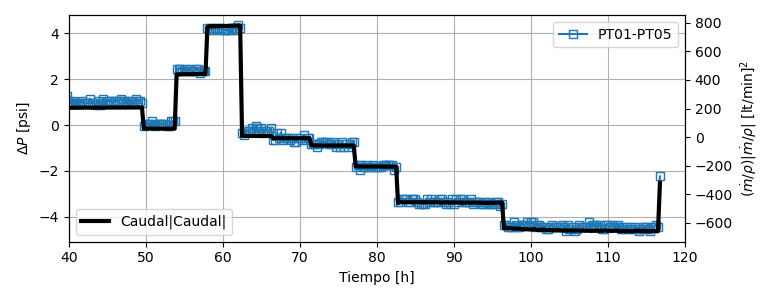

In [461]:
fig, ax = plt.subplots(1,1,figsize=(7.75,3))
#ax1,ax2 = ax
ax1 = ax
ax1b = ax1.twinx()
dt = 0.25
tiempo = np.arange(0,len(Caudal))*dt
ax1b.plot(tiempo,Caudal*np.abs(Caudal),color='k',linewidth=3,label='Caudal|Caudal|');
#ax1.plot((PT01-PT03),label = 'PT01-PT03',marker =  'o',fillstyle='none')
ax1.plot(tiempo,(PT01-PT05),label = 'PT01-PT05',marker =  's',fillstyle='none')
ax1.grid()
ax1.legend()
ax1b.legend(loc='lower left')
#ax2.plot(np.asarray(time1)/60)
#delta t = 30segundos.
ax1.set_ylabel('$\Delta P$ [psi]')
ax1b.set_ylabel(r'$(\dot m/\rho)|\dot m/\rho|$ [lt/min]$^2$')
ax1.set_xlabel('Tiempo [h]')
ax1.set_xlim([40,120])
plt.sca(ax1)
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/deltap1.tikz')

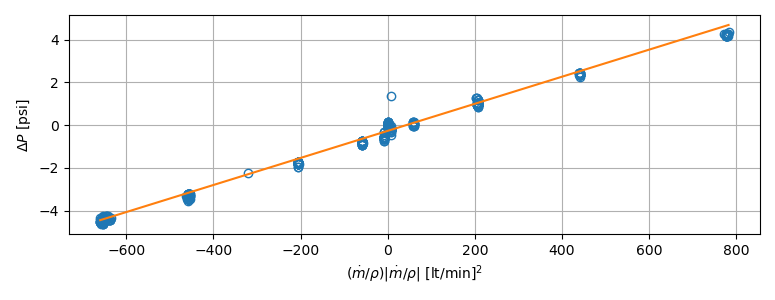

In [462]:
fig, ax = plt.subplots(1,1,figsize=(7.75,3))
#ax1,ax2 = ax
ax1 = ax
#ax1b = ax1.twinx()
dt = 0.25
tiempo = np.arange(0,len(Caudal))*dt
ax1.plot(Caudal*np.abs(Caudal),(PT01-PT05),linestyle='none',marker='o',fillstyle='none');
ax1.grid()
P1 = np.polyfit(Caudal*np.abs(Caudal),(PT01-PT05),1)

fajuste1 = np.poly1d(P1)
caudales2 = np.linspace(-(Caudal.min())**2,Caudal.max()**2,200)
ax1.plot(caudales2,fajuste1(caudales))
ax.set_ylabel('$\Delta P$ [psi]')
ax1.set_xlabel(r'$(\dot m/\rho)|\dot m/\rho|$ [lt/min]$^2$')
plt.tight_layout()

savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/deltap2.tikz')


In [442]:
P1

array([ 0.00634302, -0.26736708])

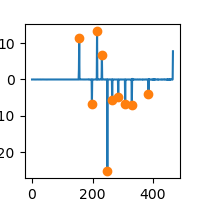

In [443]:
fig,ax = plt.subplots(figsize=(2,2))
ax.plot(np.diff(Caudal))
picos = find_peaks(np.abs(np.diff(Caudal)),threshold=1)
ax.plot(picos[0],np.diff(Caudal)[picos[0]],'o')

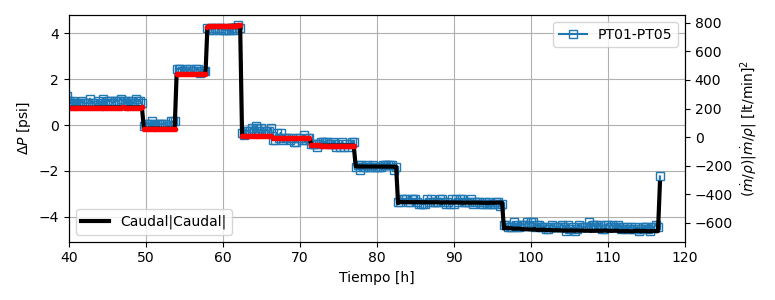

In [444]:
picos
fig, ax = plt.subplots(1,1,figsize=(7.75,3))
#ax1,ax2 = ax
ax1 = ax
ax1b = ax1.twinx()
dt = 0.25
tiempo = np.arange(0,len(Caudal))*dt
ax1b.plot(tiempo,Caudal*np.abs(Caudal),color='k',linewidth=3,label='Caudal|Caudal|');
#ax1.plot((PT01-PT03),label = 'PT01-PT03',marker =  'o',fillstyle='none')
ax1.plot(tiempo,(PT01-PT05),label = 'PT01-PT05',marker =  's',fillstyle='none')

ax1.grid()
ax1.legend()
ax1b.legend(loc='lower left')
#ax2.plot(np.asarray(time1)/60)
#delta t = 30segundos.
ax1.set_ylabel('$\Delta P$ [psi]')
ax1b.set_ylabel(r'$(\dot m/\rho)|\dot m/\rho|$ [lt/min]$^2$')
ax1.set_xlabel('Tiempo [h]')
ax1.set_xlim([40,120])
plt.sca(ax1)
plt.tight_layout()
for i in range(7):
    ni,nf = [picos[0][i]+1,picos[0][i+1]+1]
    G =  Caudal[ni:nf]
    ax1b.plot(tiempo[ni:nf],G*np.abs(G),'r.')

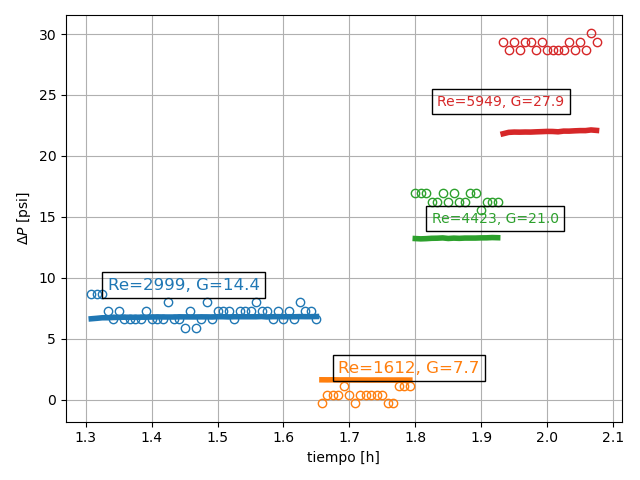

In [463]:
fig,ax = plt.subplots(clear=True)
for i in range(4):
    ni,nf = [picos[0][i]+1,picos[0][i+1]+1]
    G =  Caudal[ni:nf]
    U1 = G/(D_interno_1**2*np.pi/4)*1e-3/60
    p1,p2,p3,p4,p5,p6 = [PTi[ni:nf] for PTi in [PT01,PT02,PT03,PT04,PT05,PT06]]
    T1,T2,T3,T4,T5,T6 = [Ti[ni:nf] for Ti in TE_s[:6]]
    tiempoi = time1[ni:nf]
    Tmedia = (T1.mean()+T2.mean()+T3.mean()+T4.mean()+T5.mean())/5+273
    #################DATO a ojo
    rho_1 = densidad_f(Tmedia)
    nu_1 = np.exp(viscosidad_f(1/Tmedia))*1e-3/rho_1
    #rho = densidad.mean()
    Re_1 = U1*D_interno_1/nu_1
    L1 = 16.03
    friction_factor =  ht.conv_internal.friction_factor(np.abs(Re_1.mean()),.005)#,Method='Fang_2011',.1)
    Re = np.abs(Re_1.mean())
    #friction_factor = 0.0032+0.221*Re**-0.237
    #friction_factor = 64/Re
    deltap_1 = U1**2*0.5*rho_1*L1/D_interno_1*friction_factor

    lin, = ax.plot(tiempoi,(p1-p5)*6.89476,'o',fillstyle='none')
    ax.plot(tiempoi,deltap_1*1e-3*np.sign(G.mean()),color=lin.get_color(),linewidth=4);
    #ax.text(tiempoi[10],deltap_1[10]*1e-3,f'{nu_1:.3e},{Re_1[10]:.0f},{friction_factor:.4f}')
    
    if i==2:
        t= ax.text(tiempoi[3],deltap_1[1]*1e-3*np.sign(G.mean())*1.1,f'Re={Re:.0f}, G={G.mean():.1f}',color=lin.get_color())
    elif i==3:
        t= ax.text(tiempoi[0]-.1,deltap_1[1]*1e-3*np.sign(G.mean())*1.1,f'Re={Re:.0f}, G={G.mean():.1f}',color=lin.get_color())
    else:
        t = ax.text(tiempoi[3],deltap_1[1]*1e-3*np.sign(G.mean())*1.35,f'Re={Re:.0f}, G={G.mean():.1f}', fontsize=12,color=lin.get_color())  
        #ax.plot([time1[ni],time1[nf]],[(p1-p5)[0]*6.89476,(p1-p5)[-1]*6.89476],'ko')
    t.set_bbox(dict(facecolor='none',  edgecolor='k'))
ax.set_xlabel('tiempo [h]')    
ax.set_ylabel('$\Delta P$ [psi]')
ax.grid()
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/deltap_diferencia.tikz')

#ax.set_ylim([0,-10])

${\displaystyle L_{h,turbulent}=1.359D(Re_{D})^{1/4}}$

In [483]:
A = pd.read_excel('Pruebas diesel 24-08-2022 20.xlsx',thousands=',')
A = pd.read_excel('Pruebas diesel 31-08-2022 calib DP y quitar resistencia.xlsx',thousands=',')
A = pd.read_excel('Pruebas diesel 19-09-2022 500 rpm 40 50 60C.xlsx',thousands=',')
#A = A[:944]
#A.drop(A.columns[[1]],axis=1,inplace=True)
A=A.drop(A.index[[0,1,2]])
A = A[:-5]


In [488]:
A

,Date/Time,PT-01,PT-02,PT-03,PT-04,PT-05,PT-06,VESSEL_SP,VESSEL_OP,TE-01,...,TE-13,CORIOLIS_Temperature,CORIOLIS_VolFlow,DPT-01,OnOffMotor,SDS_Mesure,CHILLER_PV,CHILLER_SP,CORIOLIS_Density,Motor
3,21:04:52,???,???,???,???,???,???,@@@@@,@@@@@,???,...,???,???,???,???,???,???,???,???,???,???
4,21:05:07,65.1,57.2,59.3,59.2,64.6,57.9,30,4,18,...,17.2,18.9,-0.448,-25,0,0.001443,18.1,30,0.825,-2000
5,21:05:22,65.6,57.7,59.7,59.7,65.1,58.3,30,3,18,...,17.2,19.3,-0.464,-25,0,0.001478,18.1,30,0.824,-2000
6,21:05:37,67.3,58.7,60.6,60.3,65.6,58.6,30,3,18.2,...,17.3,19.5,-0.384,-25,1,0.002072,18.1,30,0.824,-2000
7,21:05:52,66.4,58.3,60.3,60.4,65.8,58.8,30,2.9,18.8,...,17.2,20.2,5793,-25,1,0.042319,18.1,30,0.829,-200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,03:51:33,62.7,57.5,58.2,58.9,61.5,54.3,30,0,53.7,...,42.5,56.1,19908,-25,1,?????,43.5,30,0.799,-1500
1628,03:51:48,62.6,57.5,58.1,58.8,61.5,54.3,30,0,53.5,...,41.8,55.8,19882,-25,1,?????,43.2,30,0.799,-1500
1629,03:52:03,62.5,57.4,58.3,59,61.5,54.3,30,0,53.3,...,41.3,55.5,19912,-25,1,?????,43.1,30,0.8,-1500
1630,03:52:18,62.5,57.3,58.1,58.8,61.4,54.2,30,0,53,...,41,55.1,19922,-25,1,?????,43,30,0.8,-1500


In [466]:
B = pd.read_csv('Datos 19092022')
dpdata = B.to_numpy().T[0]
dt2 = 1/3600
time2 = np.arange(0,len(dpdata)*dt2,dt2)

In [476]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(dpdata, time2, is_sorted=True, frac=0.01, it=0)

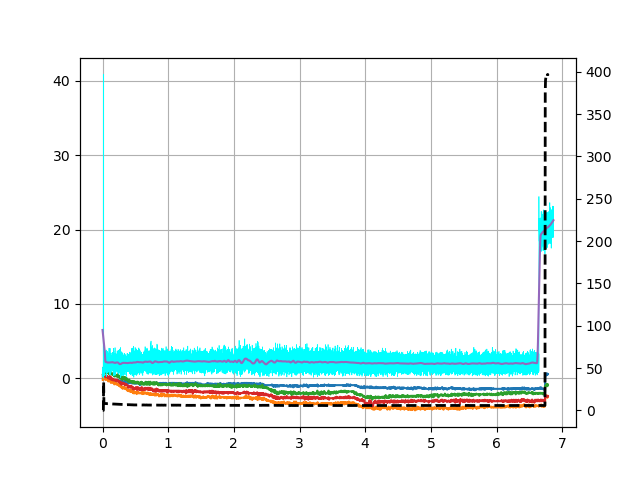

In [477]:
#PT01,PT02,PT03,PT04,PT05,PT06  = [pd.to_numeric(A.iloc[:,i].to_numpy()) for i in range(1,7)]
Caudal = pd.to_numeric(A['CORIOLIS_VolFlow'],errors='coerce').to_numpy()/1000
dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)
indices = np.logical_not(np.isnan(Caudal))
#Caudal[np.isnan(Caudal)] = 0
#Caudal[np.abs(Caudal)>100] = 0
densidad = pd.to_numeric(A['CORIOLIS_Density'],errors='ignore').to_numpy()


TE_s = np.tile(np.zeros_like(Caudal),[12,1])
PT_s = np.tile(np.zeros_like(Caudal),[6,1])
for i in range(10,22):
    TE_s[i-10] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
for i in range(1,6):
    PT_s[i-1] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()-PT_ref[i-1]
#PTs = pd.to_numeric(A.iloc[:,list(range(2,7))],errors='coerce')
#ax.plot(Caudal)

Tchiller_pv, Tchiller_sp = [pd.to_numeric(A.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]
fig,ax = plt.subplots()
ax.plot(time1,PT_s[0]-PT_s[4])
ax.plot(time1,PT_s[0]-PT_s[3])
ax.plot(time1,PT_s[0]-PT_s[2])
ax.plot(time1,PT_s[0]-PT_s[1])
axb = ax.twinx()
axb.plot(time1,Caudal*np.abs(Caudal),color='black',linestyle='--',linewidth=2)
ax.grid()

ax.plot(time2,dpdata*10,'cyan',linewidth=0.5)
ax.plot(filtered[:,0],filtered[:,1]*10)

In [481]:
PT_ref

array([ 6.45875, -1.1425 ,  1.17625,  0.3175 ,  5.91625, -0.3475 ])

In [478]:
B = pd.read_csv('Datos 19092022')
dpdata = B.to_numpy().T[0]
dt2 = 1/3600
time2 = np.arange(0,len(dpdata)*dt2,dt2)

In [479]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(dpdata, time2, is_sorted=True, frac=0.01, it=0)

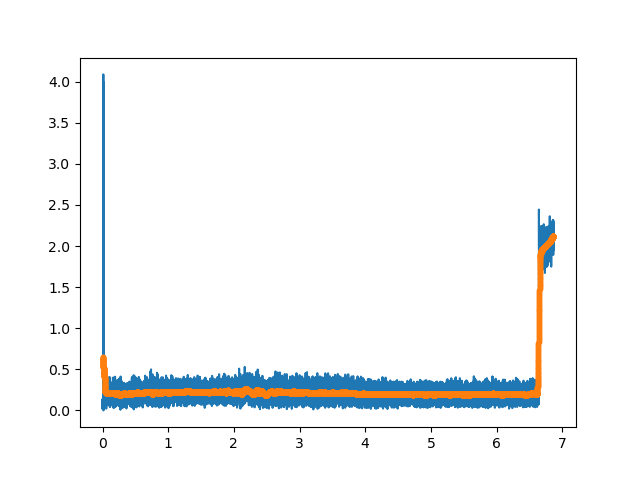

In [480]:
dpdata = B.to_numpy()
fig,ax = plt.subplots()
ax.plot(time2,dpdata)
ax.plot(filtered[:,0],filtered[:,1],'.-')
#yhat = savgol_filter(dpdata, 15, 3) # window size 51, polynomial order 3
#ax.plot(yhat)

In [388]:
filtered[:,0].shape

(24721,)

In [316]:
#variables presion
PT01,PT02,PT03,PT04,PT05,PT06  = [pd.to_numeric(A3.iloc[:,i].to_numpy()) for i in range(1,7)]
# variables temperaturas
TE_s = np.tile(np.zeros_like(PT01),[12,1])
for i in range(9,21):
    TE_s[i-9] = pd.to_numeric(A3.iloc[:,i].to_numpy()) 
# variable caudal
Caudal = pd.to_numeric(A3['CORIOLIS_VolFlow'],errors='ignore').to_numpy()
densidad = pd.to_numeric(A3['CORIOLIS_Density'],errors='ignore').to_numpy()
Caudal[156:] = Caudal[156:]/1e3
# para -175 motor corresponde 2.465 l/min
Vmotor = pd.to_numeric(A3.iloc[:,30].to_numpy()) 
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A3.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]
Tchiller_pv[Tchiller_pv =='???'] = np.NaN
Tchiller_sp[Tchiller_sp =='???'] = np.NaN
dt = 30
N = len(Vmotor)
time1  = np.arange(0,dt*N,dt)/3600

#referencias
#datos valores sin flujo
PT01_ref,PT02_ref,PT03_ref,PT04_ref,PT05_ref,PT06_ref = [PTi[:160].mean() for PTi in [PT01,PT02,PT03,PT04,PT05,PT06]]
#PT01_ref,PT02_ref,PT03_ref,PT04_ref,PT05_ref,PT06_ref = [6.46, -1.14, 1.17, 0.3175, 5.91625, -0.3475]
PT01 = PT01 - PT01_ref
PT02 = PT02 - PT02_ref
PT03 = PT03 - PT03_ref
PT04 = PT04 - PT04_ref
PT05 = PT05 - PT05_ref
PT06 = PT06 - PT06_ref

TypeError: unsupported operand type(s) for /: 'str' and 'float'


$$k ( T ) = A e − E a R T {\displaystyle k(T)=A{\mathrm {e} }^{-{\frac {E_{\mathrm {a} }}{RT}}}} {\displaystyle k(T)=A{\mathrm {e} }^{-{\frac {E_{\mathrm {a} }}{RT}}}} $$

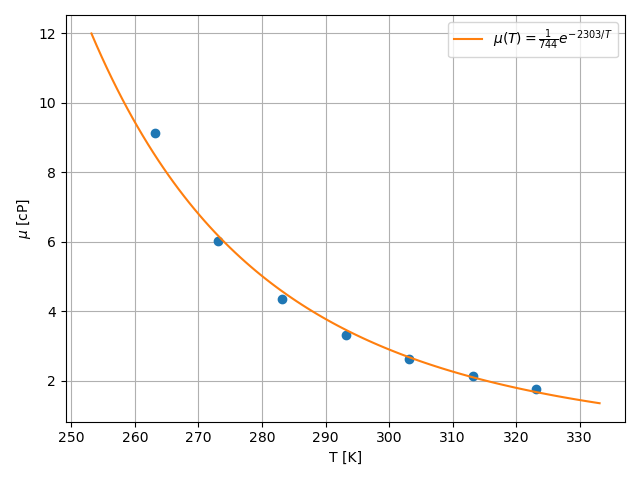

In [141]:
fig,ax = plt.subplots()
ax.plot(Temps,Viscosidad,'o')
etiqueta_viscosidad = f'$\mu(T)=\\frac{{1}}{{{1/np.exp(P1[1]):.0f}}}e^{{-{P1[0]:.0f}/T}}$'
ax.plot(temperaturas,np.exp(viscosidad_f(1/temperaturas)),label=etiqueta_viscosidad)
#ax.plot(temperaturas,np.exp(P1[1])*np.exp(P1[0]/temperaturas))
ax.legend()
ax.set_ylabel('$\mu$ [cP]')
ax.set_xlabel('T [K]')
ax.grid()
plt.tight_layout()
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/viscosidad.tikz')

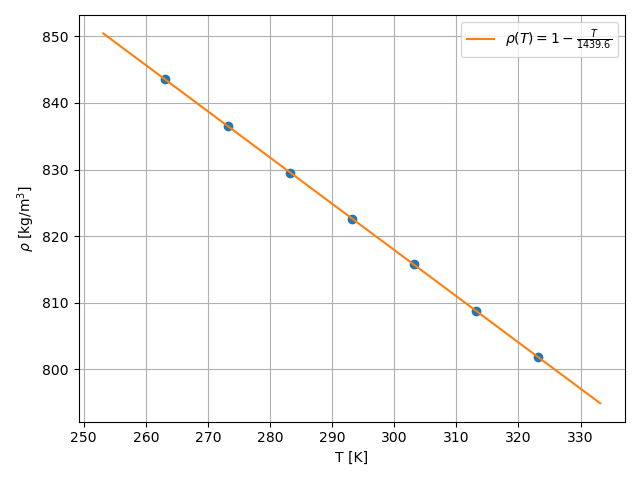

In [157]:
fig,ax = plt.subplots()
ax.plot(Temps,1000*Densidad,'o')
etiqueta_densidad = f'$\\rho(T)={P2[1]:.0f}-\\frac{{T}}{{{-1/P2[0]:.1f}}}$'
ax.plot(temperaturas,1000*densidad_f(temperaturas),label=etiqueta_densidad)
ax.legend()
ax.grid()
ax.set_xlabel('T [K]')
ax.set_ylabel(r'$\rho$ [kg/m$^3$]')
plt.tight_layout()

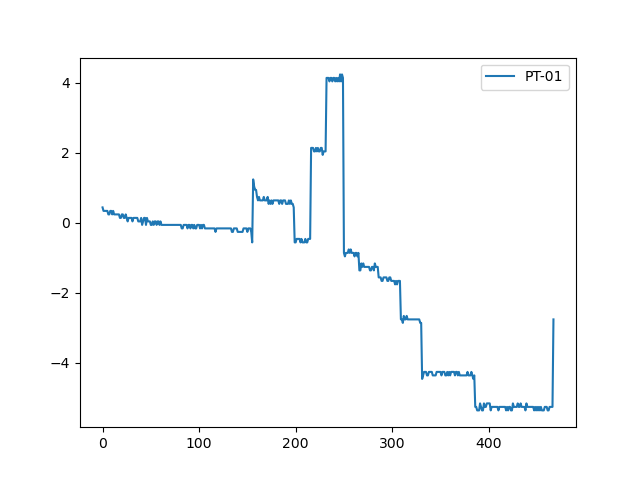

In [161]:
#EXPERIENCIA 2
# 655 HASTA 700
n_inicio,n_final = [0,870]
fig2,ax2 = plt.subplots(clear=True)
ax2.plot(PT01[n_inicio:n_final],label='PT-01')
#ax2.plot(time1[n_inicio:n_final],PT02[n_inicio:n_final],label='PT-02');
#ax2.plot(time1[n_inicio:n_final],PT03[n_inicio:n_final],label='PT-03');
#ax2.plot(time1[n_inicio:n_final],PT04[n_inicio:n_final],label='PT-04');
#ax2.plot(time1[n_inicio:n_final],PT05[n_inicio:n_final],label='PT-05')
#ax2.plot(time1[n_inicio:n_final],PT06[n_inicio:n_final],label='PT-06')

ax2.legend(ncol=4)

In [137]:
# Propiedades Físicas
T_crudo_media = (T_crudo_e+T_crudo_s)/2
T_glycol_media = (T_glycol_e+T_glycol_s)/2  # en caso de faltar un temperatura, tomar de la otra corriente

Cp_crudo = 2100 # [J/Kg K]
Cp_glycol = cp.CoolProp.PropsSI('C','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
rho_crudo = 850
rho_glycol = cp.CoolProp.PropsSI('D','T',273+ T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
mu_crudo  = cp.CoolProp.PropsSI('V','T',273+T_crudo_media,'P',101325,'Water')*10
mu_glycol = cp.CoolProp.PropsSI('V','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
nu_crudo = mu_crudo/rho_crudo
nu_glycol = mu_glycol/rho_glycol
k_crudo = 0.13
k_glycol = cp.CoolProp.PropsSI('L','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
a_crudo = k_crudo/(rho_crudo*Cp_crudo)    #difusividad térmica
a_glycol = k_glycol/(rho_glycol*Cp_glycol)

Pr_crudo = nu_crudo/a_crudo
Pr_glycol = nu_glycol / a_glycol

Pr_glycol2 = cp.CoolProp.PropsSI('Prandtl','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')

[datos](https://material-properties.org/es/combustible-diesel-densidad-punto-de-fusion-conductividad-termica/)

In [14]:
Q_crudo = Cp_crudo*Caudal_crudo*rho_crudo*(T_crudo_e-T_crudo_s)
Q_glycol = Q_crudo
Caudal_glycol = Q_glycol / (Cp_glycol*(T_glycol_s-T_glycol_e) *rho_glycol)
display(Latex(f'Calor Intercambiado: $Q={Q_crudo*1e-3:.2f}$kW'))

<IPython.core.display.Latex object>

In [12]:
[Cp_crudo*Caudal_crudo*rho_crudo,Cp_glycol*Caudal_glycol*rho_glycol]

[67.38375, 185.30531249999945]

### Eficiencia térmica. Calor Intercambiado.

In [15]:
#Capacidad Térmica Mínima
Capacidades_termicas = np.array([Cp_crudo*Caudal_crudo*rho_crudo,Cp_glycol*Caudal_glycol*rho_glycol])
Fluidos = ['Crudo','Glycol']
Cmin = np.min(Capacidades_termicas)
fluido_cmin = Fluidos[np.argmin(Capacidades_termicas)]
#Mayor Salto Térmico del sistema
DeltaT_max = T_crudo_e- T_glycol_e
#Calor Máximo disponible
Qmax = Cmin*DeltaT_max
#ficiencia térmica
eficiencia = Q_crudo/Qmax

 
print(f'Capacidad Térmica Mínima Cmin = %.1f W/K'%Cmin)
print(f'Fluido Cmin: '+fluido_cmin)
print(f'Calor Máximo disponible Qmax=%.1f kW'%(Qmax*1e-3))
print(f'Eficiencia térmica del equipo = %.2f'%eficiencia)


Capacidad Térmica Mínima Cmin = 67.4 W/K
Fluido Cmin: Crudo
Calor Máximo disponible Qmax=1.1 kW
Eficiencia térmica del equipo = 0.19


## LMTD, área y Coeficiente Global 


In [17]:
LMTD = ht.LMTD(Tci=T_glycol_e, Tco=T_glycol_s, Thi=T_crudo_e, Tho=T_crudo_s)

Area = D_interno*np.pi*Longitud
#######################
U = Q_crudo/(LMTD*Area)

display(Latex(f'Conductancia Global U={U:.1f}W/m$^2$'))

Area_pasaje_crudo = (D_interno**2*np.pi/4)
Veloc_crudo = Caudal_crudo / Area_pasaje_crudo

Area_pasaje_glycol = ( (D_externo**2-D_interno**2)*np.pi/4)
Perimetro_glycol = D_interno*np.pi+D_externo*np.pi

Veloc_glycol  = Caudal_glycol / Area_pasaje_glycol


D_hidraulico_glycol = 4*Area_pasaje_glycol / Perimetro_glycol

display(Latex(f'Velocidad crudo $V_{{crudo}}={Veloc_crudo:.3f}$m/s'))
display(Latex(f'Velocidad crudo $V_{{glycol}}={Veloc_glycol:.3f}$m/s'))


#Aire.veloc = Aire.caudal / Aire.area
#Aire.Reynolds()
#Npasotubos =  Re_design*(np.pi*Tubo_dext-Tubo_esp*2*Ntubos_0*m ) / (4*m_t)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

ŽUKAUSKAS, A. Heat transfer from tubes in crossflow. En Advances in heat transfer. Elsevier, 1972. p. 93-160.

In [18]:
Re_crudo = Veloc_crudo * D_interno / nu_crudo
Re_glycol = Veloc_glycol * D_hidraulico_glycol / nu_glycol
Nu_crudo = ht.conv_internal.turbulent_Colburn(Re_crudo,Pr_crudo)
Nu_glycol = ht.conv_internal.turbulent_Colburn(Re_glycol,Pr_glycol)
hc_crudo = Nu_crudo*k_crudo/D_interno
hc_glycol = Nu_glycol*k_glycol/D_hidraulico_glycol
display(Latex(f'$Re_{{crudo}}={Re_crudo:.0f}$,$Nu_{{crudo}}={Nu_crudo:.1f}$, $hc_{{crudo}}={hc_crudo:.0f}$'))
display(Latex(f'$Re_{{glycol}}={Re_glycol:.0f}$,    $Nu_{{glycol}}={Nu_glycol:.1f}$,$hc_{{glycol}}={hc_glycol:.0f}$'))
#print('Coeficiente conveccion aire = %.1f'%Aire.hc)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

COLBURN, Allan P. A method of correlating forced convection heat-transfer data and a comparison with fluid friction. International Journal of Heat and Mass Transfer, 1964, vol. 7, no 12, p. 1359-1384.

In [21]:
k_acero = ht.k_material('stainless steel')
espesor_tubo = 1e-3

In [22]:
Ulimpio = (1/ (hc_crudo*D_interno) + np.log((D_interno+espesor_tubo)/D_interno)/k_acero + 1/(hc_glycol*(D_interno+espesor_tubo)))**-1
#U_calc = 1 / (1/Ulimpio + Rf *(1+Tubo_dext/Tubo_dint))



In [23]:
1/ (np.log((D_interno+espesor_tubo)/D_interno)/k_acero ), (hc_crudo*D_interno) 

(440.2452970082708, 1.2961839923607767)

In [22]:
Ulimpio,hc_crudo

(4.270114968579573, 1531.9786379170362)

In [24]:
# Caida de presion

# Calculo para flujo en tubos
roughness = fluids.roughness_Farshad('Carbon steel, bare', D=D_interno)
roughness_gl = fluids.roughness_Farshad('Carbon steel, bare', D=D_hidraulico_glycol)

f_c = fluids.friction.friction_factor(Re=Re_crudo, eD=roughness/D_interno)
f_c2 = 1.2*(0.0014+0.125/Re_crudo**.32)
f_c_gl = fluids.friction.friction_factor(Re=Re_glycol, eD=roughness_gl/D_hidraulico_glycol)

Delta_p_crudo = f_c*Veloc_crudo**2*Longitud/D_interno/2 
Delta_p_glycol = f_c_gl*Veloc_glycol**2*Longitud/D_hidraulico_glycol/2 

display(Latex(f'$\Delta p_{{crudo}}={Delta_p_crudo}$Pa'))
display(Latex(f'$\Delta p_{{glycol}}={Delta_p_glycol}$Pa'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
print('Se puede volcar sobre un archivo Excel.')
# Workbook is created 
wb = xw.Workbook() 
xw.add_palette_colour("gris", 0x21)
wb.set_colour_RGB(0x21, 200, 200,200)  
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Performance Unidad') 
style = xw.easyxf('pattern: pattern solid, fore_colour gris;')
# Input data into rows 
sheet1.write(3, 0, 'Nombre Fluido') 
sheet1.write(3, 1, 'Crudo') 
sheet1.write(3, 2, 'Glycol 50%') 

sheet1.write(4, 0, 'Caudal masico (kg/s)',style) 
sheet1.write(4, 1, '%.2f'%(Caudal_crudo*rho_crudo),style) 
sheet1.write(4, 2, '%.2f'%(Caudal_glycol*rho_glycol),style) 

sheet1.write(5, 0, 'Temperatura Entrada') 
sheet1.write(5, 1, '%.1f'%T_crudo_e) 
sheet1.write(5, 2, '%.1f'%T_glycol_e) 

sheet1.write(6, 0, 'Temperatura salida',style) 
sheet1.write(6, 1, f'{T_crudo_s:.1f}',style) 
sheet1.write(6, 2, f'{T_glycol_s:.1f}',style) 
sheet1.write(7, 0, 'Densidad kg/m3') 
sheet1.write(7, 1, f'{rho_crudo:.0f}')
sheet1.write(7, 2, f'{rho_glycol:.0f}')
sheet1.write(8, 0, 'Viscosidad cP',style) 
sheet1.write(8, 1, f'{mu_crudo*1e3:.1f}',style) 
sheet1.write(8, 2, f'{mu_glycol*1e3:.1f}',style) 


sheet1.write(9, 0, 'Calor específico J/Kg C')
sheet1.write(9, 1, f'{Cp_crudo:.0f}')
sheet1.write(9, 2, f'{Cp_glycol:.0f}')


sheet1.write(10, 0, 'Conductividad térmica W/Kg C',style) 
sheet1.write(10, 1, f'{k_crudo:.2f}',style) 
sheet1.write(10, 2, f'{k_glycol:.2f}',style) 

sheet1.write(11, 0, 'Presión de entrada kPa') 
sheet1.write(11, 1, '%.1f'%(101.3))
sheet1.write(11, 2, '%.1f'%(101.3))


sheet1.write(12, 0, 'Velocidad m/s',style) 
sheet1.write(12, 1, f'{Veloc_crudo:.1f}',style)
sheet1.write(12, 2, f'{Veloc_glycol:.1f}',style)


sheet1.write(13, 0, 'Caída de presión Pa') 
sheet1.write(13, 1, f'{Delta_p_crudo:.1f}')
sheet1.write(13, 2, f'{Delta_p_glycol:.1f}')


sheet1.write(14, 0, 'Resistencia de ensuciamiento m2C/W',style) 
#sheet1.write(14, 1, '%.4f'%(Rf/2),style)
#sheet1.write(14, 2, '%.4f'%(Rf/2),style)

sheet1.write(15, 0, 'Calor intercambiado kW') 
sheet1.write(15, 1, f'{Q_crudo*1e-3}')

sheet1.write(16, 0, 'Coeficiente Global de Transferencia',style)
sheet1.write(16, 1, f'{U:.1f}',style)

nombre_salida = 'Intercambiador_salida.xls'
wb.save(nombre_salida)
data_salida_excel = pd.read_excel('./'+nombre_salida,skiprows=2)
data_salida_excel

Se puede volcar sobre un archivo Excel.


,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Nombre Fluido,Crudo,Glycol 50%
1,Caudal masico (kg/s),0.28,0.29
2,Temperatura Entrada,60.0,-20.0
3,Temperatura salida,22.0,5.0
4,Densidad kg/m3,850,1078
5,Viscosidad cP,6.4,11.4
6,Calor específico J/Kg C,2100,3159
7,Conductividad térmica W/Kg C,0.13,0.37
8,Presión de entrada kPa,101.3,101.3
9,Velocidad m/s,4.7,0.6


In [25]:
calcular volumen de parafina necesario.... tres veces lo que deposita 5mm en la pared

SyntaxError: invalid syntax (2619805294.py, line 1)

In [28]:
Diam = 25.4e-3
Diam_para = 25.4e-3-2.5e-3

Vol_para = (Diam**2*np.pi/4-Diam_para**2*np.pi/4)*Longitud

In [29]:
Vol_para*1e3

1.5173892516838692